<a href="https://colab.research.google.com/github/astroChance/RadNET/blob/master/RadNET_Frontend.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and Directories

In [1]:
!pip install --upgrade segyio
import segyio
import numpy as np
from math import sqrt
import matplotlib
import matplotlib.pyplot as plt
import time
import itertools
import os
import re
import random
from PIL import Image
from scipy import spatial, signal
import json
from sklearn.preprocessing import StandardScaler


plt.style.use('classic')
# plt.style.use('seaborn')

     |████████████████████████████████| 92kB 3.8MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
### Data filepaths

# 3D

Volume3D = "/content/drive/My Drive/RadNET/GAN data/3D/PB3D_Fritz_subset.sgy"

# 2D

TwoDFiles = []
for root, dirs, files in os.walk("/content/drive/My Drive/RadNET/GAN data/2D"):
    for name in files:
        filename = os.path.join(root, name)
        TwoDFiles.append(filename)
print("2D files in directory: ", len(TwoDFiles))

2D files in directory:  139


# Create 2D-3D Trace Match Dictionary

In [ ]:
"""
Design dictionary of:
{2D line number from filename : { 2D trace number : corresponding 3D trace number}

NOTE: Placing TRACE_SEQUENCE_LINE header into match dictionary requires a -1 to be
used later when accessing traces (numpy index != TRACE_SEQUENCE_LINE)

Due to runtime limitations in Colab, write each 2D dict to json file then
concatenate in next cell
"""



# 3D trace coord dictionary, {(Xcoord, Ycoord) : 3D trace number}
# Create array of XY coords for min dist calculation
Trace_coords_3D = {}
coord_3D = np.array([])
counter3D = 0
with segyio.open(Volume3D, 'r') as segyfile:
  for i in range(len(segyfile.trace)):
    Trace_coords_3D[(segyfile.header[i][segyio.TraceField.GroupX], segyfile.header[i][segyio.TraceField.GroupY])] = segyfile.header[i][segyio.TraceField.TRACE_SEQUENCE_LINE]
    tr_coord = np.array([ segyfile.header[i][segyio.TraceField.GroupX], segyfile.header[i][segyio.TraceField.GroupY] ])
    if counter3D == 0:
      coord_3D = np.append(coord_3D, tr_coord)
    else:
      coord_3D = np.vstack((coord_3D, tr_coord))
    counter3D =+ 1

print("3D trace dictionary complete")


# For each 2D line, build dictionary to map 2D trace number
# to closest 3D trace number

TEMP_DICT = {}

line_counter=1
for radar_line in TwoDFiles[52:]:
  with segyio.open(radar_line, 'r') as line:
    line_num = os.path.basename(radar_line).split(".")[0]

    TEMP_DICT = {}
    TEMP_DICT[line_num] = {}

    trace_counter=1
    for i in range(len(line.trace)):
      trace_2D = line.header[i][segyio.TraceField.TRACE_SEQUENCE_LINE]
      
      ## Find 3D nearest neighbor for x and y
      ## minimize (dx + dy)
      coord_2D = np.array([ line.header[i][segyio.TraceField.GroupX], line.header[i][segyio.TraceField.GroupY] ])
      
      closest_3Dtrace = coord_3D[spatial.KDTree(coord_3D).query(coord_2D)[1]]
      closest_3Dtrace = tuple(closest_3Dtrace)

      ## Build the dictionary
     
      TEMP_DICT[line_num][trace_2D] = [Trace_coords_3D[closest_3Dtrace]]
      
      print("\rLine number ", line_counter, "\tTrace number ", trace_counter, "\\",len(line.trace), end="", flush=True)
      trace_counter+=1

    temp_Dict = "/content/drive/My Drive/RadNET/GAN data/tempdicts/" + str(line_num) + ".json"
    with open(temp_Dict, 'w') as dict_file:
      json.dump(TEMP_DICT, dict_file)

    line_counter+=1


print("\nIndividual dictionaries complete")

In [ ]:
# Check json file count
# Place all individual dicts into master dict

Trace_Map_Dict = "/content/drive/My Drive/RadNET/GAN data/2D_to_3D_Trace_Dict.json"

Trace_Matcher = {}

indv_dicts = []
for root, dirs, files in os.walk("/content/drive/My Drive/RadNET/GAN data/tempdicts"):
    for name in files:
        filename = os.path.join(root, name)
        indv_dicts.append(filename)
print("2D files in directory: ", len(indv_dicts))

for dic in indv_dicts:
  with open(dic, 'r') as temp_dict:
    tempdict = json.load(temp_dict)
    Trace_Matcher.update(tempdict)


with open(Trace_Map_Dict, 'w') as dict_file:
      json.dump(Trace_Matcher, dict_file)

In [ ]:
# QC the trace match dictionary

Trace_Map_Dict = "/content/drive/My Drive/RadNET/GAN data/2D_to_3D_Trace_Dict.json"
with open(Trace_Map_Dict, 'r') as TraceDictFile:
  TraceDict = json.load(TraceDictFile)

print("Loaded data type: ", type(TraceDict))

trace_count=0
for k,v in TraceDict.items():
  trace_count = trace_count + len(v)

print("Trace matched pairs: ", trace_count)

print("Random Sample: ", random.choice(list(TraceDict.items())))

# temp section for figures, delete later

In [13]:
plt.style.use('default')

In [27]:
print(len(TraceDict.items()))

print(sum(len(v)for v in TraceDict.values()))

138
64818


In [38]:
Rand2D_test = random.choice(list(TraceDict.items()))
RandTraceMatch_test = random.choice(list(Rand2D_test[1].items()))
# print(RandTraceMatch_test)
print(Rand2D_test)

('1591601000', {'1': [250505], '2': [250004], '3': [249504], '4': [249003], '5': [248502], '6': [248002], '7': [247501], '8': [247502], '9': [247001], '10': [246501], '11': [246000], '12': [245500], '13': [244999], '14': [244499], '15': [244499], '16': [243999], '17': [243498], '18': [242997], '19': [242497], '20': [241996], '21': [241496], '22': [240995], '23': [240996], '24': [240495], '25': [239995], '26': [239494], '27': [238994], '28': [238493], '29': [237993], '30': [237993], '31': [237492], '32': [236992], '33': [236491], '34': [235991], '35': [235490], '36': [234990], '37': [234990], '38': [234490], '39': [233989], '40': [233489], '41': [232988], '42': [232488], '43': [231987], '44': [231486], '45': [231487], '46': [230986], '47': [230486], '48': [229985], '49': [229485], '50': [228984], '51': [228484], '52': [228484], '53': [227984], '54': [227483], '55': [226983], '56': [226482], '57': [225981], '58': [225481], '59': [224980], '60': [224981], '61': [224480], '62': [223980], '

In [32]:
# how many NOT dead 2D traces are there?
# assume that all 3D traces are live

live_traces = 0
for line, match_dict in TraceDict.items():
  segy2D = "/content/drive/My Drive/RadNET/GAN data/2D/" + str(line) + ".sgy"
  with segyio.open(segy2D, 'r') as segyfile:
    for i in range(len(segyfile.trace)):
      if np.amax(segyfile.trace[i]) < -100:
        continue
      else:
        live_traces += 1
print(live_traces)


64572


In [40]:
## get 2D-3D distance values

distances = []

with segyio.open(Volume3D, 'r') as segyfile_3D:

  for line, match_dict in TraceDict.items():
    segy2D = "/content/drive/My Drive/RadNET/GAN data/2D/" + str(line) + ".sgy"

    with segyio.open(segy2D, 'r') as segyfile_2D:

      for i in range(len(segyfile_2D.trace)):

        dict_2D = str(i+1)
        tr_3d = match_dict[dict_2D][0] - 1

        x_2d = segyfile_2D.header[i][segyio.TraceField.GroupX]
        y_2d = segyfile_2D.header[i][segyio.TraceField.GroupY]

        x_3d = segyfile_3D.header[tr_3d][segyio.TraceField.GroupX]
        y_3d = segyfile_3D.header[tr_3d][segyio.TraceField.GroupY]

        distance = sqrt( (x_3d-x_2d)**2 + (y_3d-y_2d)**2 )
        distances.append(distance)

64818
335.1686142824235
0.0


(array([ 1005.,  3037.,  5003.,  7141.,  9250., 10961., 13341.,  9254.,
         4416.,  1410.]),
 array([  0.        ,  33.51686143,  67.03372286, 100.55058428,
        134.06744571, 167.58430714, 201.10116857, 234.61803   ,
        268.13489143, 301.65175285, 335.16861428]),
 <a list of 10 Patch objects>)

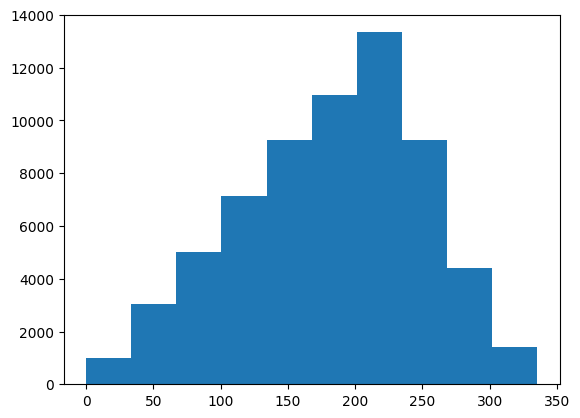

In [44]:
print(len(distances))
print(max(distances))
print(min(distances))
plt.hist(distances)

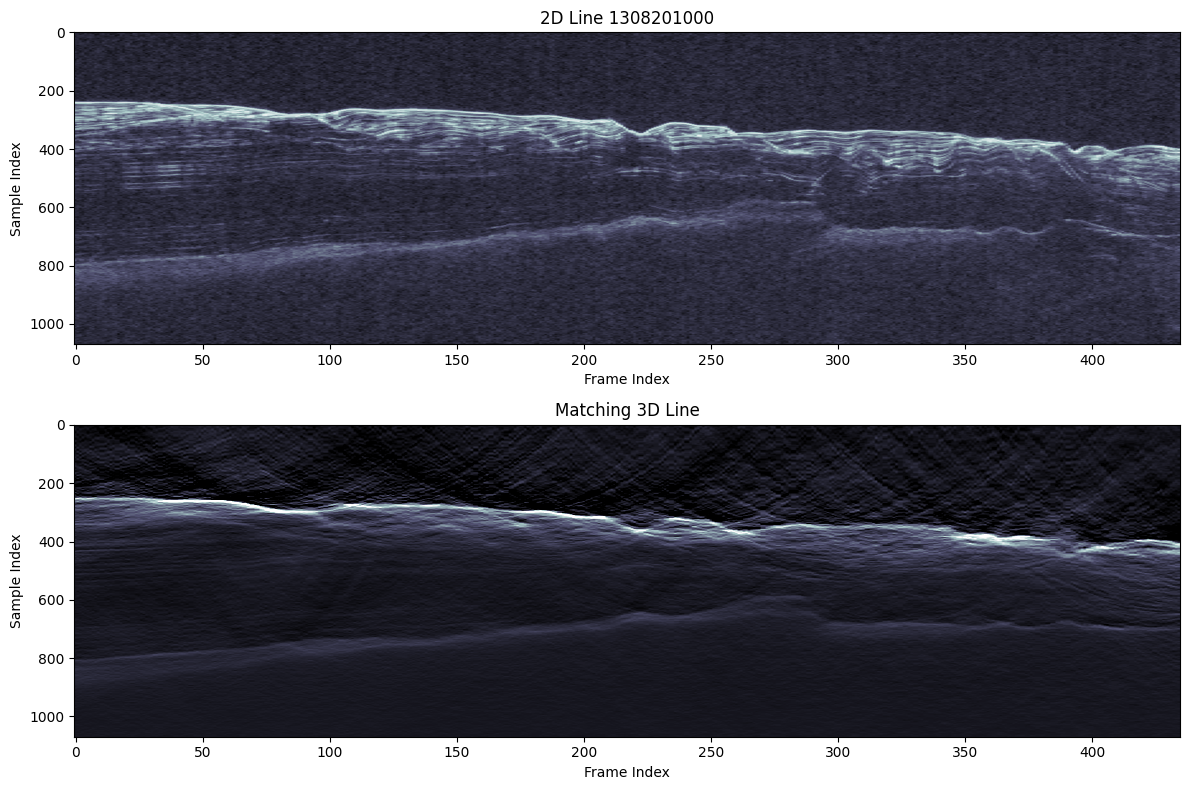

In [48]:
# Trimming 2D data to approximately match 3D
trace_len_clip_2D_start = 1970
trace_len_clip_2D_end = 3040


# # Load dictionary to get 2D / 3D trace relationships
# Trace_Map_Dict = "/content/drive/My Drive/RadNET/GAN data/2D_to_3D_Trace_Dict.json"
# with open(Trace_Map_Dict, 'r') as TraceDictFile:
#   TraceDict = json.load(TraceDictFile)

# # Randomly choose value from trace match dictionary
# Rand2D = random.choice(list(TraceDict.items()))

# # Set the random choice to variables, print information
# Rand2DLine = int(Rand2D[0])


# Get 2D and 3D data
Rand2DFile = "/content/drive/My Drive/RadNET/GAN data/2D/" + str(Rand2DLine) + ".sgy"
with segyio.open(Rand2DFile, 'r') as segyfile:
  display_line2D = segyio.tools.collect(segyfile.trace[:])
  display_line2D = display_line2D[:,trace_len_clip_2D_start:trace_len_clip_2D_end]

with segyio.open(Volume3D, 'r') as segyfile:
  counter = 0
  display_line3D = np.array([])

  for tr in TraceDict[str(Rand2DLine)].values():
  # for tr in Rand2D[1].values():

    if counter == 0:
      display_line3D = np.append(display_line3D, segyfile.trace[tr[0]])
    else:
      display_line3D = np.vstack((display_line3D, segyfile.trace[tr[0]]))
    counter += 1

fig, ax = plt.subplots(2,1, figsize=(12,8))
ax[0].set_title("2D Line " + str(Rand2DLine))
ax[0].imshow(display_line2D.T, cmap='bone', aspect='auto')
ax[0].set_ylabel('Sample Index')
ax[0].set_xlabel('Frame Index')

ax[1].set_title("Matching 3D Line")
ax[1].imshow(display_line3D.T, cmap='bone', vmin = -1, vmax = 8, aspect='auto')
ax[1].set_ylabel('Sample Index')
ax[1].set_xlabel('Frame Index')

plt.tight_layout()
plt.show()

In [ ]:
example_line = '1308201000'
example_dir = "/content/drive/MyDrive/RadNET/GAN data/Enhanced_Line_Section/Line1308201000_3Dtraces/"

with segyio.open(Volume3D, 'r') as segyfile:

  for k, v in TraceDict[example_line].items():
    idx = int(k)-1
    tr_3d = segyfile.trace[v[0]-1]


    scaler3D = StandardScaler()
    standardized_3D_trace = scaler3D.fit_transform(np.expand_dims(tr_3d, axis=1))

    ### Zxx parameters
    fs = 1 / 0.0000000375     #sample frequency
    nperseg = 128        
    noverlap = 96
    window = signal.hann(nperseg, sym=False)

    colormap = 'jet'
    min_val = -10
    max_val = 1
    shading = 'flat'

  # Reshaping (based on nperseg/noverlap) and upscaling
    standardized_3D_trace = standardized_3D_trace[30:-20]
    _3D_trace = np.squeeze(standardized_3D_trace)

  # Perform STFT
    _, _, Zxx3D = signal.stft(_3D_trace, window = window, fs = fs, nperseg = nperseg, noverlap=noverlap)
    
    Mag_3D = np.abs(Zxx3D)

    Mag_3D_expand = np.zeros((256, 256))
    
    dim_0_repeat = 3
    dim_1_repeat = 7
    
    Mag_3D_repeat = np.repeat(Mag_3D, dim_0_repeat, axis=0)
    Mag_3D_repeat = np.repeat(Mag_3D_repeat, dim_1_repeat, axis=1)
    
    Mag_3D_expand[30:30+Mag_3D_repeat.shape[0], 12:12+Mag_3D_repeat.shape[1]] = Mag_3D_repeat

  # Save image at log scale
    Log_Mag_3D_expand = np.log(Mag_3D_expand)

    plt.imsave(os.path.join(example_dir, str(idx)+"_1308201000_3D") + ".png", 
               Log_Mag_3D_expand, cmap=colormap, vmin=min_val, vmax=max_val)

# Visual QC of Matched Sections

In [ ]:
"""
Display 2D and corresponding 3D line sections

Display standardized matched traces

Display PSD and Magnitude Spectrograms of standardized matched traces

"""


####!!!!!!!  REPLACE WITH SMARTER MATCHING?
#
# Trimming 2D data to approximately match 3D
trace_len_clip_2D_start = 1970
trace_len_clip_2D_end = 3040


# Load dictionary to get 2D / 3D trace relationships
Trace_Map_Dict = "/content/drive/My Drive/RadNET/GAN data/2D_to_3D_Trace_Dict.json"
with open(Trace_Map_Dict, 'r') as TraceDictFile:
  TraceDict = json.load(TraceDictFile)

# Randomly choose value from trace match dictionary
Rand2D = random.choice(list(TraceDict.items()))
RandTraceMatch = random.choice(list(Rand2D[1].items()))

# Set the random choice to variables, print information
Rand2DLine = int(Rand2D[0])
Rand2DTrace = int(RandTraceMatch[0]) - 1
Rand3DTrace = int(RandTraceMatch[1][0]) - 1

print("2D line: ", Rand2DLine)
print("2D trace: ", Rand2DTrace)
print("3D trace: ", Rand3DTrace)


# Get 2D and 3D data
Rand2DFile = "/content/drive/My Drive/RadNET/GAN data/2D/" + str(Rand2DLine) + ".sgy"
with segyio.open(Rand2DFile, 'r') as segyfile:
  display_line2D = segyio.tools.collect(segyfile.trace[:])
  display_line2D = display_line2D[:,trace_len_clip_2D_start:trace_len_clip_2D_end]
  display_trace_2D = segyfile.trace[Rand2DTrace]
  display_trace_2D = display_trace_2D[trace_len_clip_2D_start:trace_len_clip_2D_end]

with segyio.open(Volume3D, 'r') as segyfile:
  display_trace_3D = segyfile.trace[Rand3DTrace]
  counter = 0
  display_line3D = np.array([])
  for tr in Rand2D[1].values():

    if counter == 0:
      display_line3D = np.append(display_line3D, segyfile.trace[tr[0]])
    else:
      display_line3D = np.vstack((display_line3D, segyfile.trace[tr[0]]))
    counter += 1

# Using StandardScaler to adjust relative ampltidues of 2D and 3D traces
scaler2D = StandardScaler()    
scaler3D = StandardScaler()
standardized_2D_trace = scaler2D.fit_transform(np.expand_dims(display_trace_2D, axis=1))
standardized_3D_trace = scaler3D.fit_transform(np.expand_dims(display_trace_3D, axis=1))


# Extra trim applied to shape spectrogram array size
# Done for image size convenience, can revisit later
standardized_2D_trace = np.squeeze(standardized_2D_trace[30:-20])
standardized_3D_trace = np.squeeze(standardized_3D_trace[30:-20])


# Paramters for STFT
fs = 1 / 0.0000000375     #sample frequency
nperseg = 128        # Potential nperseg/noverlap combos to use: (128, 96), (256,192/128)
noverlap = 96
window = signal.hann(nperseg, sym=False)

# Display parameters for Spectrograms
colormap = 'jet'
min_val = -10
max_val = 1
shading = 'flat'

# Use Welch method to get Power Spectral Density
freqs_2D, PSD_2D = signal.welch(standardized_2D_trace, window = window, fs = fs, nperseg = nperseg, noverlap=noverlap)
freqs_3D, PSD_3D = signal.welch(standardized_3D_trace, window = window, fs = fs, nperseg = nperseg, noverlap=noverlap)

# Run STFT on standardized traces
f2D, t2D, Zxx2D = signal.stft(standardized_2D_trace, window = window, fs = fs, nperseg = nperseg, noverlap=noverlap)
f3D, t3D, Zxx3D = signal.stft(standardized_3D_trace, window = window, fs = fs, nperseg = nperseg, noverlap=noverlap)


# Make plots
plt.figure(figsize=(10,4))
plt.title("2D Line " + str(Rand2DLine))
plt.imshow(display_line2D.T, cmap='bone', aspect='auto')
plt.axvline(Rand2DTrace, color='red')
plt.colorbar()

plt.figure(figsize=(10,4))
plt.title("3D Arb Line")
plt.imshow(display_line3D.T, cmap='bone', vmin = 0, vmax = 13, aspect='auto')
plt.axvline(Rand2DTrace, color='red')
plt.colorbar()

plt.figure(figsize=(10,3))
plt.plot(standardized_2D_trace, linewidth=1, label='Standardized 2D Trace')
plt.plot(standardized_3D_trace, linewidth=1, label='Standardized 3D Trace')
plt.legend()
plt.show()


fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].semilogy(freqs_2D/1000000, PSD_2D)  # div by 1e6 to display MHz
ax[0].set_ylabel('Power')
ax[0].set_xlabel('Frequency [MHz]')
ax[0].set_title('2D Power Spectral Density')

ax[1].semilogy(freqs_3D/1000000, PSD_3D)  # div by 1e6 to display MHz
ax[1].set_ylabel('Power')
ax[1].set_xlabel('Frequency [MHz]')
ax[1].set_title('3D Power Spectral Density')
plt.show()


fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].pcolormesh(t2D, f2D/1000000, np.log(np.abs(Zxx2D)), cmap=colormap, vmin=min_val, vmax=max_val, shading='flat')  # div by 1e6 to display MHz
ax[0].set_ylabel('Frequency [MHz]')
ax[0].set_xlabel('Time [unit]')
ax[0].set_title('2D Trace STFT (log10)')

ax[1].pcolormesh(t3D, f3D/1000000, np.log(np.abs(Zxx3D)), cmap=colormap, vmin=min_val, vmax=max_val, shading='flat')   # div by 1e6 to display MHz
ax[1].set_ylabel('Frequency [MHz]')
ax[1].set_xlabel('Time [unit]')
ax[1].set_title('3D Trace STFT (log10)')
plt.show()

# Write image files

In [ ]:
# Write test files of 2D and 3D

file_to_write = 20000

output_file_dir_2D = ""
output_file_dir_3D = ""

Trace_Map_Dict = "/content/drive/My Drive/RadNET/GAN data/2D_to_3D_Trace_Dict.json"
with open(Trace_Map_Dict, 'r') as TraceDictFile:
    TraceDict = json.load(TraceDictFile)

## toggle these off if doing subsequent mini batch runs
## also must increase file_counter comparator for subsequent mini batches
trace_list_2D = []
file_counter=0

while file_counter < file_to_write:

    # Randomly choose value from trace match dictionary
    Rand2D = random.choice(list(TraceDict.items()))
    RandTraceMatch = random.choice(list(Rand2D[1].items()))

    # Set the random choice to variables, print information
    # The dictionary captures trace numbers from TRACE_SEQUENCE_LINE,
    # which compared to the numpy array is index + 1, therefore need to 
    # subtract 1 to get the proper index value
    Rand2DLine = int(Rand2D[0])
    Rand2DTrace = int(RandTraceMatch[0])-1
    Rand3DTrace = int(RandTraceMatch[1][0])-1

    # check if we've already grabbed the random trace
    if (str(Rand2DLine)+str(Rand2DTrace)) in trace_list_2D:
        continue
    trace_list_2D.append(str(Rand2DLine)+str(Rand2DTrace))


  # Get the random 2D and 3D trace data
    Rand2DFile = "./2D/" + str(Rand2DLine) + ".sgy"
    with segyio.open(Rand2DFile, 'r') as segyfile:
        display_trace_2D = segyfile.trace[Rand2DTrace]
        display_trace_2D = display_trace_2D[1970:3040]
        
    # Check for dead 2D traces
    if np.amax(display_trace_2D) < -100:
        continue

    with segyio.open(Volume3D, 'r') as segyfile:
        display_trace_3D = segyfile.trace[Rand3DTrace]


  # Using StandardScaler to adjust relative ampltidues of 2D and 3D
    scaler2D = StandardScaler()    
    scaler3D = StandardScaler()
    standardized_2D_trace = scaler2D.fit_transform(np.expand_dims(display_trace_2D, axis=1))
    standardized_3D_trace = scaler3D.fit_transform(np.expand_dims(display_trace_3D, axis=1))

  ### Zxx parameters
    fs = 1 / 0.0000000375     #sample frequency
    nperseg = 128        
    noverlap = 96
    window = signal.hann(nperseg, sym=False)

    colormap = 'jet'
    min_val = -10
    max_val = 1
    shading = 'flat'

  # Reshaping (based on nperseg/noverlap) and upscaling
    standardized_2D_trace = standardized_2D_trace[30:-20]
    standardized_3D_trace = standardized_3D_trace[30:-20]
    _2D_trace = np.squeeze(standardized_2D_trace)
    _3D_trace = np.squeeze(standardized_3D_trace)

  # Perform STFT
    _, _, Zxx2D = signal.stft(_2D_trace, window = window, fs = fs, nperseg = nperseg, noverlap=noverlap)
    _, _, Zxx3D = signal.stft(_3D_trace, window = window, fs = fs, nperseg = nperseg, noverlap=noverlap)
    
    Mag_2D = np.abs(Zxx2D)
    Mag_3D = np.abs(Zxx3D)

  # Expand dimensions to 256 x 256
  # Based on network being set to take 256 x 256 images
    Mag_2D_expand = np.zeros((256, 256))
    Mag_3D_expand = np.zeros((256, 256))
    
    dim_0_repeat = 3
    dim_1_repeat = 7
    
    Mag_2D_repeat = np.repeat(Mag_2D, dim_0_repeat, axis=0)
    Mag_2D_repeat = np.repeat(Mag_2D_repeat, dim_1_repeat, axis=1)
    
    Mag_3D_repeat = np.repeat(Mag_3D, dim_0_repeat, axis=0)
    Mag_3D_repeat = np.repeat(Mag_3D_repeat, dim_1_repeat, axis=1)
    
    Mag_2D_expand[30:30+Mag_2D_repeat.shape[0], 12:12+Mag_2D_repeat.shape[1]] = Mag_2D_repeat
    Mag_3D_expand[30:30+Mag_3D_repeat.shape[0], 12:12+Mag_3D_repeat.shape[1]] = Mag_3D_repeat

  # Save image at log scale
    Log_Mag_2D_expand = np.log(Mag_2D_expand)
    Log_Mag_3D_expand = np.log(Mag_3D_expand)
    
    plt.imsave(os.path.join(output_file_dir_2D, str(file_counter)+"_"+str(Rand2DLine)+"_2D_"+str(Rand2DTrace)) + ".png", 
               Log_Mag_2D_expand, cmap=colormap, vmin=min_val, vmax=max_val)
    
    plt.imsave(os.path.join(output_file_dir_3D, str(file_counter)+"_"+str(Rand2DLine)+"_3D_"+str(Rand3DTrace)) + ".png", 
               Log_Mag_3D_expand, cmap=colormap, vmin=min_val, vmax=max_val)
    
    file_counter+=1
    